# Results

1. Year long comparison of SDR and HDR
2. Comparison of the systems componets contribution to the end-to-end system
    - HDR
    - SDR
5. Anlysis of increased audience (requires 3 runs of the model with different mean growths)
6. Analysis of Stoarge intensity (SDD and HDD) for both SDR and HDR
7. Energy vs Carbon footprint (shows the variation in carbob intesity)





In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime 
import matplotlib.dates as mdates
from matplotlib.ticker import ScalarFormatter
import random

#Constant variables 
grid_width = 4
fontsize = 56
legend_fontsize = 44
line_width = 5

plot_save_path= "./plots/"

In [7]:
sheet_1 = "mean energy"
sheet_2 = "mean carbon"

#To big of a mean growth in audience
test_file = "./output/long_term_carbon_model/aud_mg_008_str_hdd_1457/summary_0506-1433.xlsx"

#BASE (BASE)(AU1)(STR1), audience mean growth of 0.006 and HHD storage value
BASE_file = "./output/long_term_carbon_model/aud_mg_0006_str_hdd_1538/summary_0506-1529.xlsx"

#AU2, audience mean growth of 0.008 and HHD storage value
AUD2_file = "./output/long_term_carbon_model/aud_mg_0008_str_hdd_1607/summary_0506-1604.xlsx"

#AU3, audience mean growth of 0.01 and HHD storage value
AUD3_file = "./output/long_term_carbon_model/aud_mg_001_str_hdd_1635/summary_0506-1630.xlsx"

#STR2, audience mean growth of 0.006 and SSD storage value
STR2_file = "./output/long_term_carbon_model/aud_mg_0006_str_sdd_1705/summary_0506-1658.xlsx"

#TEST
test_energy_df = pd.read_excel(test_file, sheet_name = sheet_1)
test_carbon_df = pd.read_excel(test_file, sheet_name = sheet_2)

#BASE
BASE_energy_df = pd.read_excel(BASE_file, sheet_name = sheet_1)
BASE_carbon_df = pd.read_excel(BASE_file, sheet_name = sheet_2)

#AUD2
AUD2_energy_df = pd.read_excel(AUD2_file, sheet_name = sheet_1)
AUD2_carbon_df = pd.read_excel(AUD2_file, sheet_name = sheet_2)

#AUD3
AUD3_energy_df = pd.read_excel(AUD3_file, sheet_name = sheet_1)
AUD3_carbon_df = pd.read_excel(AUD3_file, sheet_name = sheet_2)

#STR2
STR2_energy_df = pd.read_excel(STR2_file, sheet_name = sheet_1)
STR2_carbon_df = pd.read_excel(STR2_file, sheet_name = sheet_2)

In [9]:
#Function to extract day number
def get_day(group):
    day = group.split("_")[1]
    return int(day)

def get_hour(group):
    hour = group.split("_")[3]
    return int(hour)

def total(df):
    total = df["Origin Datacentre"] + df["Content Delivery Network"] + df["Core Network"] + df["Access Network"] + df["TV"]
    return total    

def format_dr_df(df):
    df = df.reset_index()

    df = df.drop(columns = ["Scenario","index","group"])

    df = df.rename(columns={"Origin Datacentre":"origin_datacenter","Content Delivery Network":"content_delivery_network","Core Network":"core_network","Access Network":"access_network"})
   
    df['datetime'] = df.apply(lambda row: datetime.datetime(2022, 1, 1) + datetime.timedelta(days=row['day'], hours=row['hour']), axis=1)
    df['datetime'] = pd.to_datetime(df['datetime'])
   
    df = df.set_index('datetime')
    df = df.drop(['day', 'hour'], axis=1)
   
    return df

def format_df(df):
    df["day"] = df["group"].apply(get_day)
    df["hour"] = df["group"].apply(get_hour)
    df["total"] = total(df)
    
    df = df[["Scenario","group","day","hour","Origin Datacentre","Content Delivery Network","Core Network","Access Network","TV","total"]]
    
    split_index = df.loc[df["Scenario"] == "HDR"].index[0]
    
    sdr_df = df[:split_index]  
    hdr_df = df[split_index:]
    
    sdr_df = format_dr_df(sdr_df)
    hdr_df = format_dr_df(hdr_df)

    return sdr_df,hdr_df

#resample function
def resample_daily(df):
    df = df.resample('D').sum()
    return df

def resample_monthy(df):
    df = df.resample('M').sum()
    return df

#Summaries the df to give overall sum of each column
def summarise(df):
    column_sums = df.sum()
    print(str(column_sums))
    total_sum = column_sums['total']
    column_percentages = (column_sums / total_sum) * 100
    print(str(column_percentages))
    return column_sums


## Plot functions

In [11]:
def plot_year(x,y_list,x_label,y_label,title,plot_names,fontsize,legendfontsize,grid_width,save_name):
    fig, ax = plt.subplots(figsize=(70,15))
    for i,y in enumerate(y_list):
        ax.fill_between(x, y_list[i], alpha=1, label=plot_names[i])
#         ax.plot(x, y,label = plot_names[i])
#         ax.fill_between(x, 0, y, alpha=1)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    
    ax.set_xlabel(x_label,fontsize=fontsize)
    ax.set_ylabel(y_label,fontsize=fontsize)
    ax.set_title(title,fontsize=fontsize)
    
    ax.grid(True,linewidth=grid_width)
    ax.set_xlim(x[0], x[-1])
    ax.set_ylim(bottom=0)
    
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
        
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.yaxis.offsetText.set_fontsize(fontsize)
    
    ax.legend(fontsize=legendfontsize, loc="upper center")
    
    if save_name is not None :
        file_name = plot_save_path + str(save_name) +".pdf"
        plt.savefig(file_name, bbox_inches='tight')
    
    plt.show()

    fig.clf()

def plot_year_twin(x, y1, y2, x_label, y1_label, y2_label, title, fontsize, legendfontsize, grid_width,line_width,save_name):
    fig, ax1 = plt.subplots(figsize=(70, 15))
    ax2 = ax1.twinx()
    
    ax1.plot(x, y1, label=y1_label, color='blue',linewidth= line_width)
    #ax1.fill_between(x, 0, y1, alpha=1, color='blue')
        
    ax2.plot(x, y2, label=y2_label, color='red',linewidth= line_width)
    #ax2.fill_between(x, 0, y2, alpha=1, color='red')
    
    ax1.set_xlabel(x_label, fontsize=fontsize)
    ax1.set_ylabel(y1_label, fontsize=fontsize, color='blue')
    ax2.set_ylabel(y2_label, fontsize=fontsize, color='red')
    ax1.set_title(title, fontsize=fontsize)
    
    ax1.grid(True, linewidth=grid_width)
    ax1.set_xlim(x[0], x[-1])
    ax1.set_ylim(bottom=0)
    
    ax1.tick_params(axis='x', labelsize=fontsize)
    ax1.tick_params(axis='y', labelsize=fontsize, colors='blue')
    ax2.tick_params(axis='y', labelsize=fontsize, colors='red')
    for tick in ax1.get_xticklabels():
        tick.set_rotation(45)
        
    ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax1.yaxis.offsetText.set_fontsize(fontsize)
    ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax2.yaxis.offsetText.set_fontsize(fontsize)
    
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    handles = handles1 + handles2
    labels = labels1 + labels2
    ax1.legend(handles, labels, fontsize=legendfontsize, bbox_to_anchor=(0.68, -0.35), ncol=2)
    
    if save_name is not None :
        file_name = plot_save_path + str(save_name) +".pdf"
        plt.savefig(file_name, bbox_inches='tight')
    
    plt.show()

    fig.clf()    

def plot_system_components(df,show_TV, title, xlabel, ylabel,fontsize,legendfontsize,grid_width,save_name):
    if show_TV:
        component_cols = [col for col in df.columns if col not in ['datetime', 'total']]
    else:
        component_cols = [col for col in df.columns if col not in ['datetime', 'total','TV']]
    
    fig, ax = plt.subplots(figsize=(70,15))
    df[component_cols].plot.area(alpha=0.7, zorder=2, ax=ax)

    ax.set_xlabel(xlabel,fontsize=fontsize)
    ax.set_ylabel(ylabel,fontsize=fontsize)
    ax.set_title(title,fontsize=fontsize)

    #df['total'].plot(ax=ax, color='black', linewidth=2, zorder=1)

    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

    ax.tick_params(axis='x', labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
        
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.yaxis.offsetText.set_fontsize(fontsize)
    
    ax.grid(True, alpha=0.5,linewidth=grid_width)
    ax.set_ylim(bottom=0)
    ax.legend(fontsize=legendfontsize,bbox_to_anchor=(0.85, -0.40), ncol=len(component_cols))
    
    if save_name is not None :
        file_name = plot_save_path + str(save_name) +".pdf"
        plt.savefig(file_name, bbox_inches='tight')
        
    plt.show()

        

In [13]:
#TEST
test_sdr, test_hdr = format_df(test_carbon_df)

#BASE
BASE_sdr, BASE_hdr = format_df(BASE_carbon_df)
BASE_energy_sdr, BASE_energy_hdr = format_df(BASE_energy_df)

#AUD2
AUD2_sdr, AUD2_hdr = format_df(AUD2_carbon_df)

#AUD3
AUD3_sdr, AUD3_hdr = format_df(AUD3_carbon_df)

#STR2
STR2_sdr, STR2_hdr = format_df(STR2_carbon_df)
BASE_sdr

origin_datacenter  content_delivery_network  \
datetime                                                           
2022-01-01 00:00:00           0.681158                  2.907956   
2022-01-01 01:00:00           0.349264                  1.492806   
2022-01-01 02:00:00           0.210452                  0.898624   
2022-01-01 03:00:00           0.131961                  0.563053   
2022-01-01 04:00:00           0.110965                  0.473673   
...                                ...                       ...   
2022-12-31 19:00:00           3.945145                 16.815899   
2022-12-31 20:00:00           3.096474                 13.204809   
2022-12-31 21:00:00           2.882939                 12.299295   
2022-12-31 22:00:00           2.630923                 11.229468   
2022-12-31 23:00:00           1.529925                  6.534448   

                     core_network  access_network            TV         total  
datetime                                                                       
2022-01-01 00:00:00      3.393259        3.708253   3457.042976   3467.733602  
2022-01-01 01:00:00      1.748543        1.907740   1781.699653   1787.198005  
2022-01-01 02:00:00      1.049413        1.146889   1067.417555   1070.722934  
2022-01-01 03:00:00      0.658733        0.719994    670.361062    672.434803  
2022-01-01 04:00:00      0.553768        0.604632    564.637926    566.380964  
...                           ...             ...           ...           ...  
2022-12-31 19:00:00     19.691278       21.502337  20068.026508  20129.981168  
2022-12-31 20:00:00     15.435412       16.804139  15677.078935  15725.619770  
2022-12-31 21:00:00     14.362334       15.698436  14619.092535  14664.335540  
2022-12-31 22:00:00     13.149654       14.334583  13369.341995  13410.686623  
2022-12-31 23:00:00      7.649011        8.344727   7782.051664   7806.109775  

[8760 rows x 6 columns]

# Overall stats

In [15]:
print("\nBASE---------------------------------------------------------------------------------------\n") 
print("\nSDR\n")
BASE_sdr_summary = summarise(BASE_sdr)
print("Total =" + str(BASE_sdr_summary["total"]))
print("\nHDR\n")
BASE_hdr_summary = summarise(BASE_hdr)
print("Total =" + str(BASE_hdr_summary["total"]))

print("\nAUD2---------------------------------------------------------------------------------------\n") 
print("\nSDR\n")
AUD2_sdr_summary = summarise(AUD2_sdr)
print("\nHDR\n")
AUD2_hdr_summary = summarise(AUD2_hdr)
print("Total =" + str(AUD2_hdr_summary["total"]))

print("\nAUD3---------------------------------------------------------------------------------------\n") 
print("\nSDR\n")
AUD3_sdr_summary = summarise(AUD3_sdr)
print("\nHDR\n")
AUD3_hdr_summary = summarise(AUD3_hdr)
print("Total =" + str(AUD3_hdr_summary["total"]))

print("\nSTR2---------------------------------------------------------------------------------------\n") 
print("\nSDR\n")
STR2_sdr_summary = summarise(STR2_sdr)
print("\nHDR\n")
STR2_hdr_summary = summarise(STR2_hdr)
print("Total =" + str(STR2_hdr_summary["total"]))



BASE---------------------------------------------------------------------------------------


SDR

origin_datacenter           2.266193e+04
content_delivery_network    9.670531e+04
core_network                1.131387e+05
access_network              1.234962e+05
TV                          1.151625e+08
total                       1.155185e+08
dtype: float64
origin_datacenter             0.019618
content_delivery_network      0.083714
core_network                  0.097940
access_network                0.106906
TV                           99.691822
total                       100.000000
dtype: float64
Total =115518463.83235951

HDR

origin_datacenter           4.725564e+04
content_delivery_network    1.980741e+05
core_network                2.449175e+05
access_network              2.602985e+05
TV                          1.925493e+08
total                       1.932999e+08
dtype: float64
origin_datacenter             0.024447
content_delivery_network      0.102470
core_network       

# HDR VS SDR Year comparison

In [17]:
#plot_year(test_sdr.index,[test_hdr["total"],test_sdr["total"]], "Datetime", "Carbon Emissions (CO2e)","HDR vs SDR Carbon",["HDR","SDR"],fontsize,legend_fontsize,grid_width,None)

#plot_year(BASE_sdr.index,[BASE_hdr["total"],BASE_sdr["total"]], "Datetime", "Carbon Emissions (CO2e)","HDR vs SDR Carbon",["HDR","SDR"],fontsize,legend_fontsize,grid_width,None)

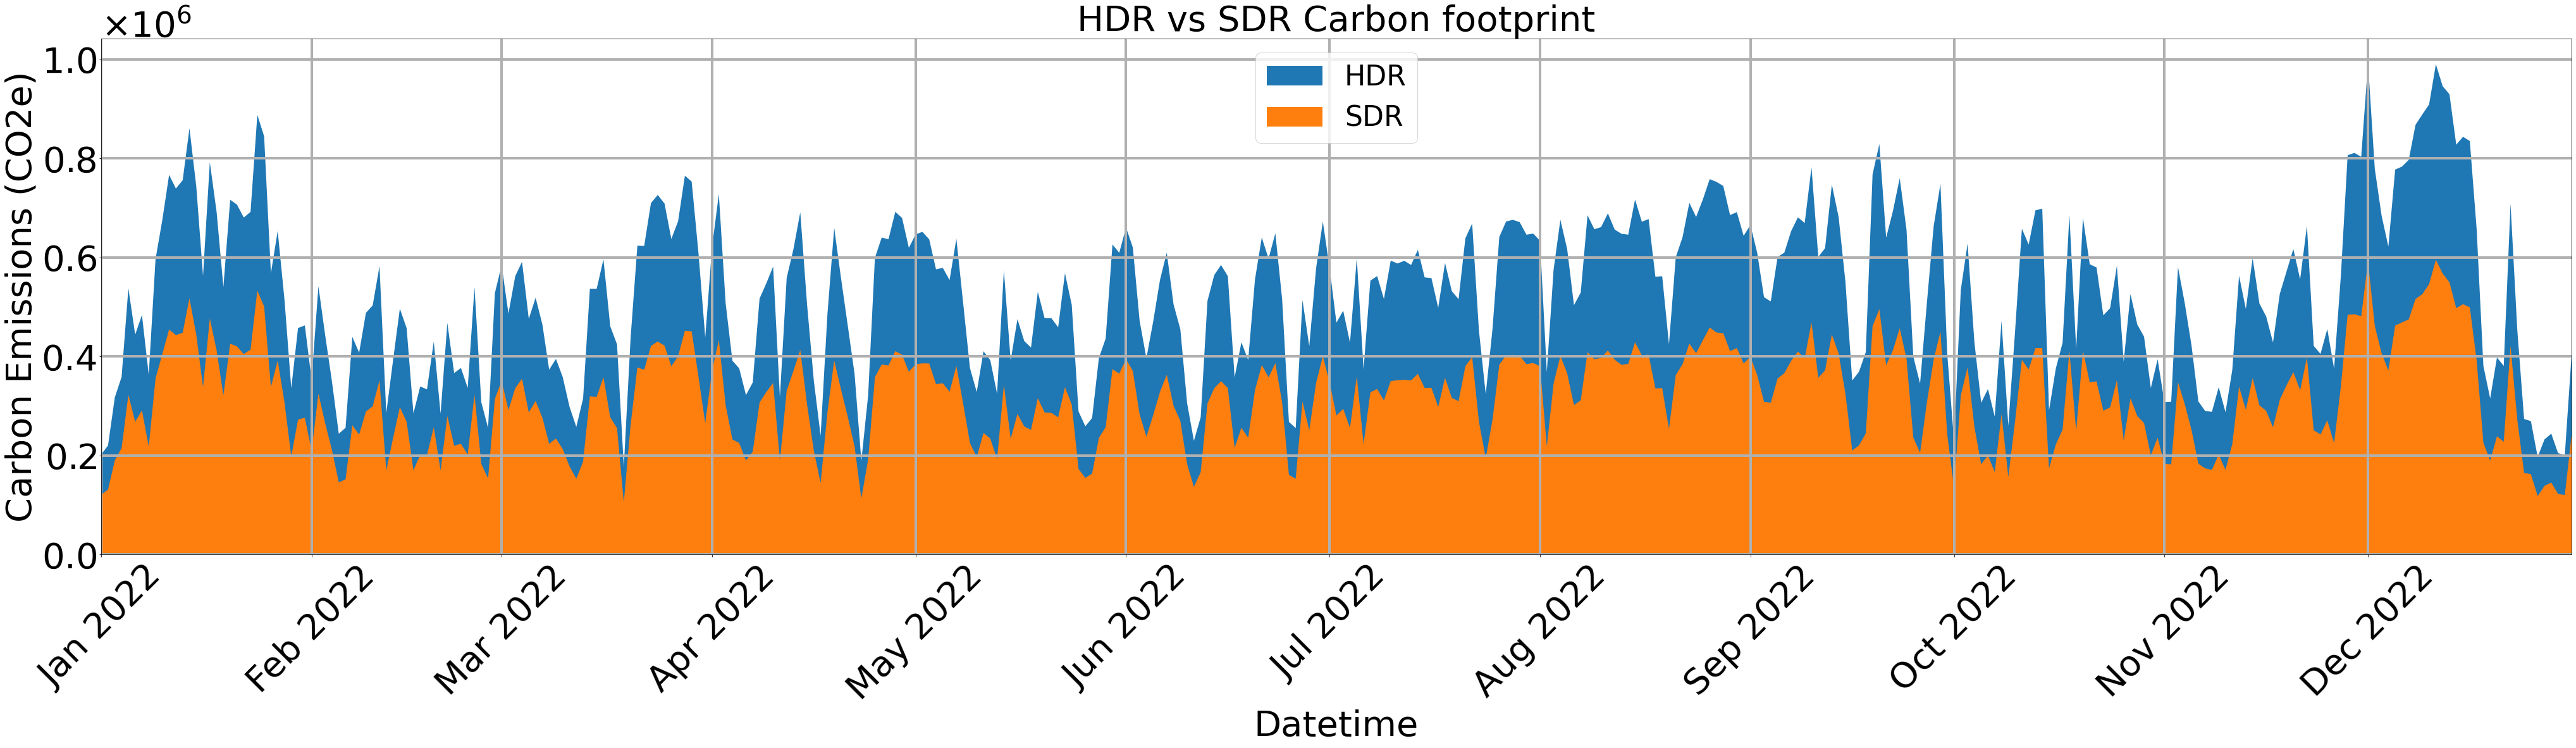

In [19]:
# test_sdr_daily = resample_daily(test_sdr)
# test_hdr_daily = resample_daily(test_hdr)
# plot_year(test_sdr_daily.index,[test_hdr_daily["total"],test_sdr_daily["total"]], "Datetime", "Carbon Emissions (CO2e)","Average HDR vs SDR Carbon",["HDR","SDR"],fontsize,legend_fontsize,grid_width)

BASE_sdr_daily = resample_daily(BASE_sdr)
BASE_hdr_daily = resample_daily(BASE_hdr)
plot_year(BASE_sdr_daily.index,[BASE_hdr_daily["total"],BASE_sdr_daily["total"]], "Datetime", "Carbon Emissions (CO2e)","HDR vs SDR Carbon footprint",["HDR","SDR"],fontsize,legend_fontsize,grid_width,"hdr_sdr")

## Year different figure

In [21]:
# temp = summarise(BASE_sdr)

# STR2 = summarise(STR2_sdr)

# Plot comparing System Components

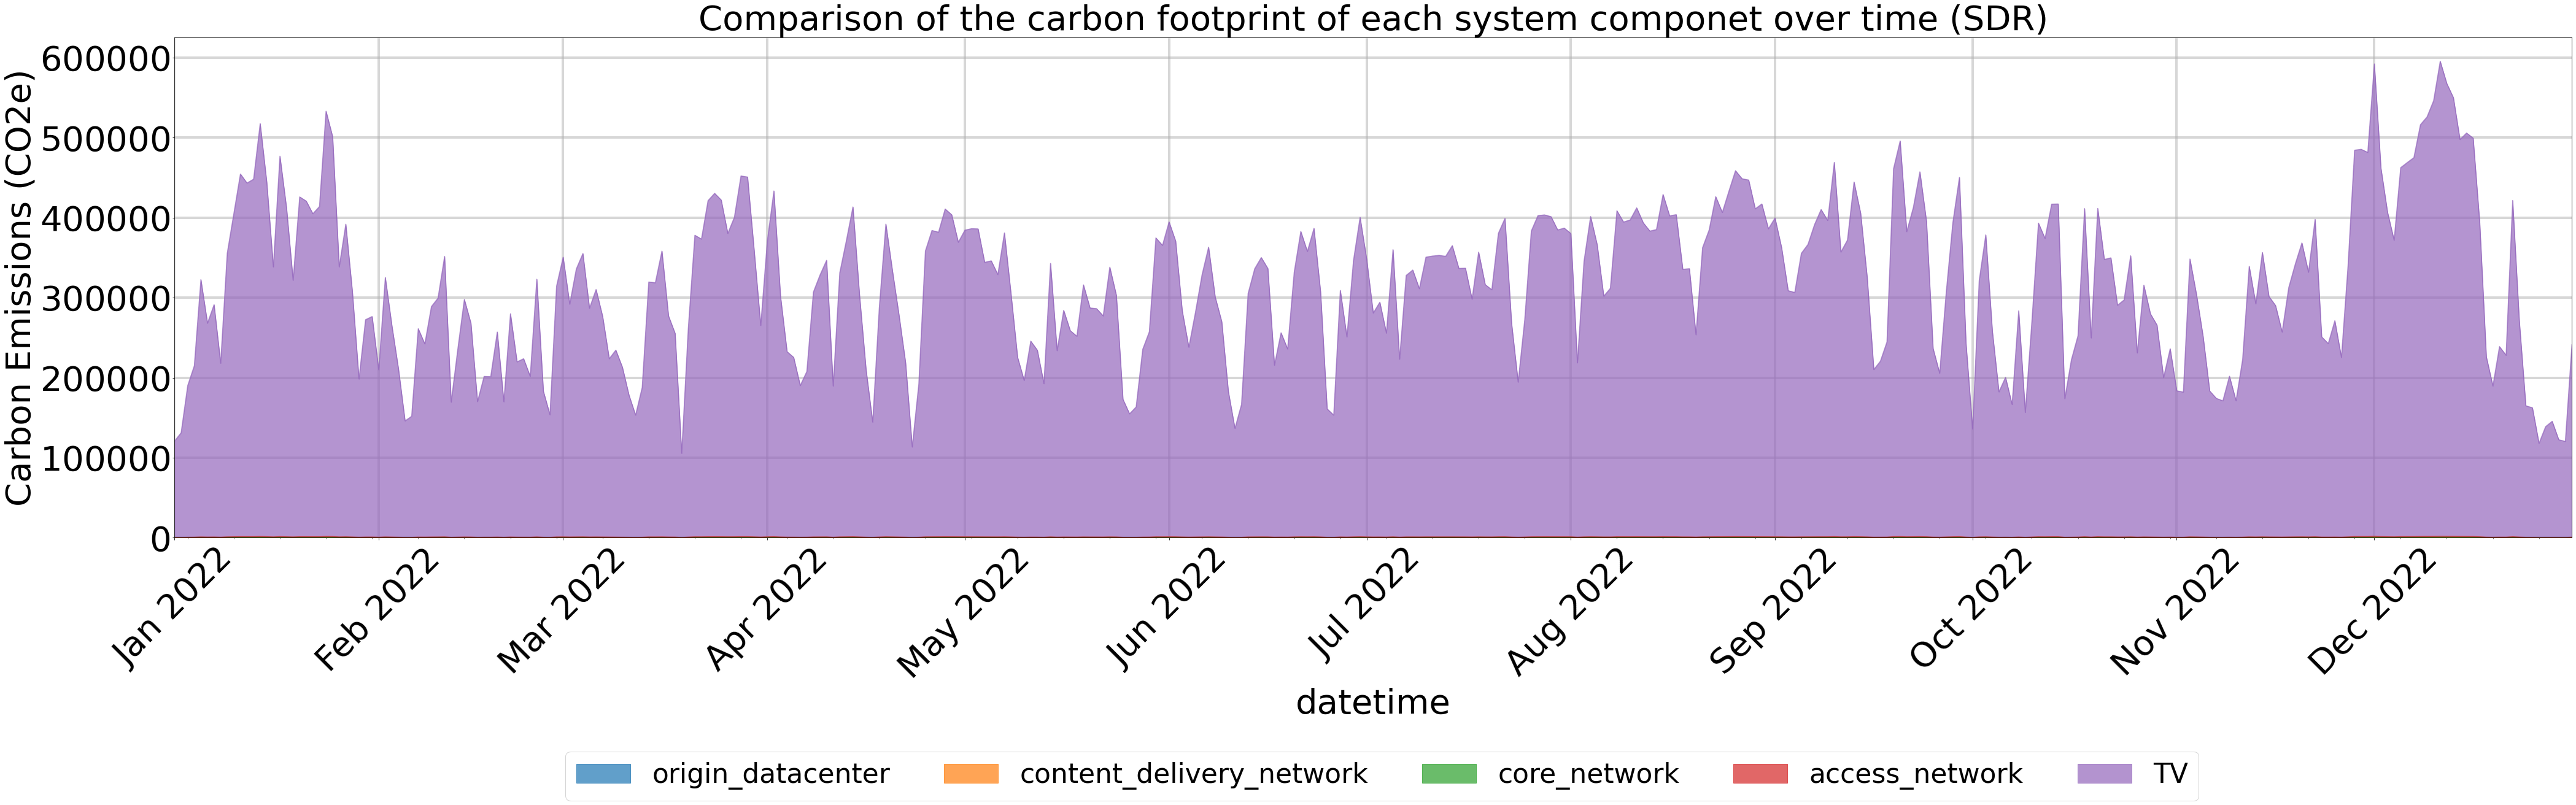

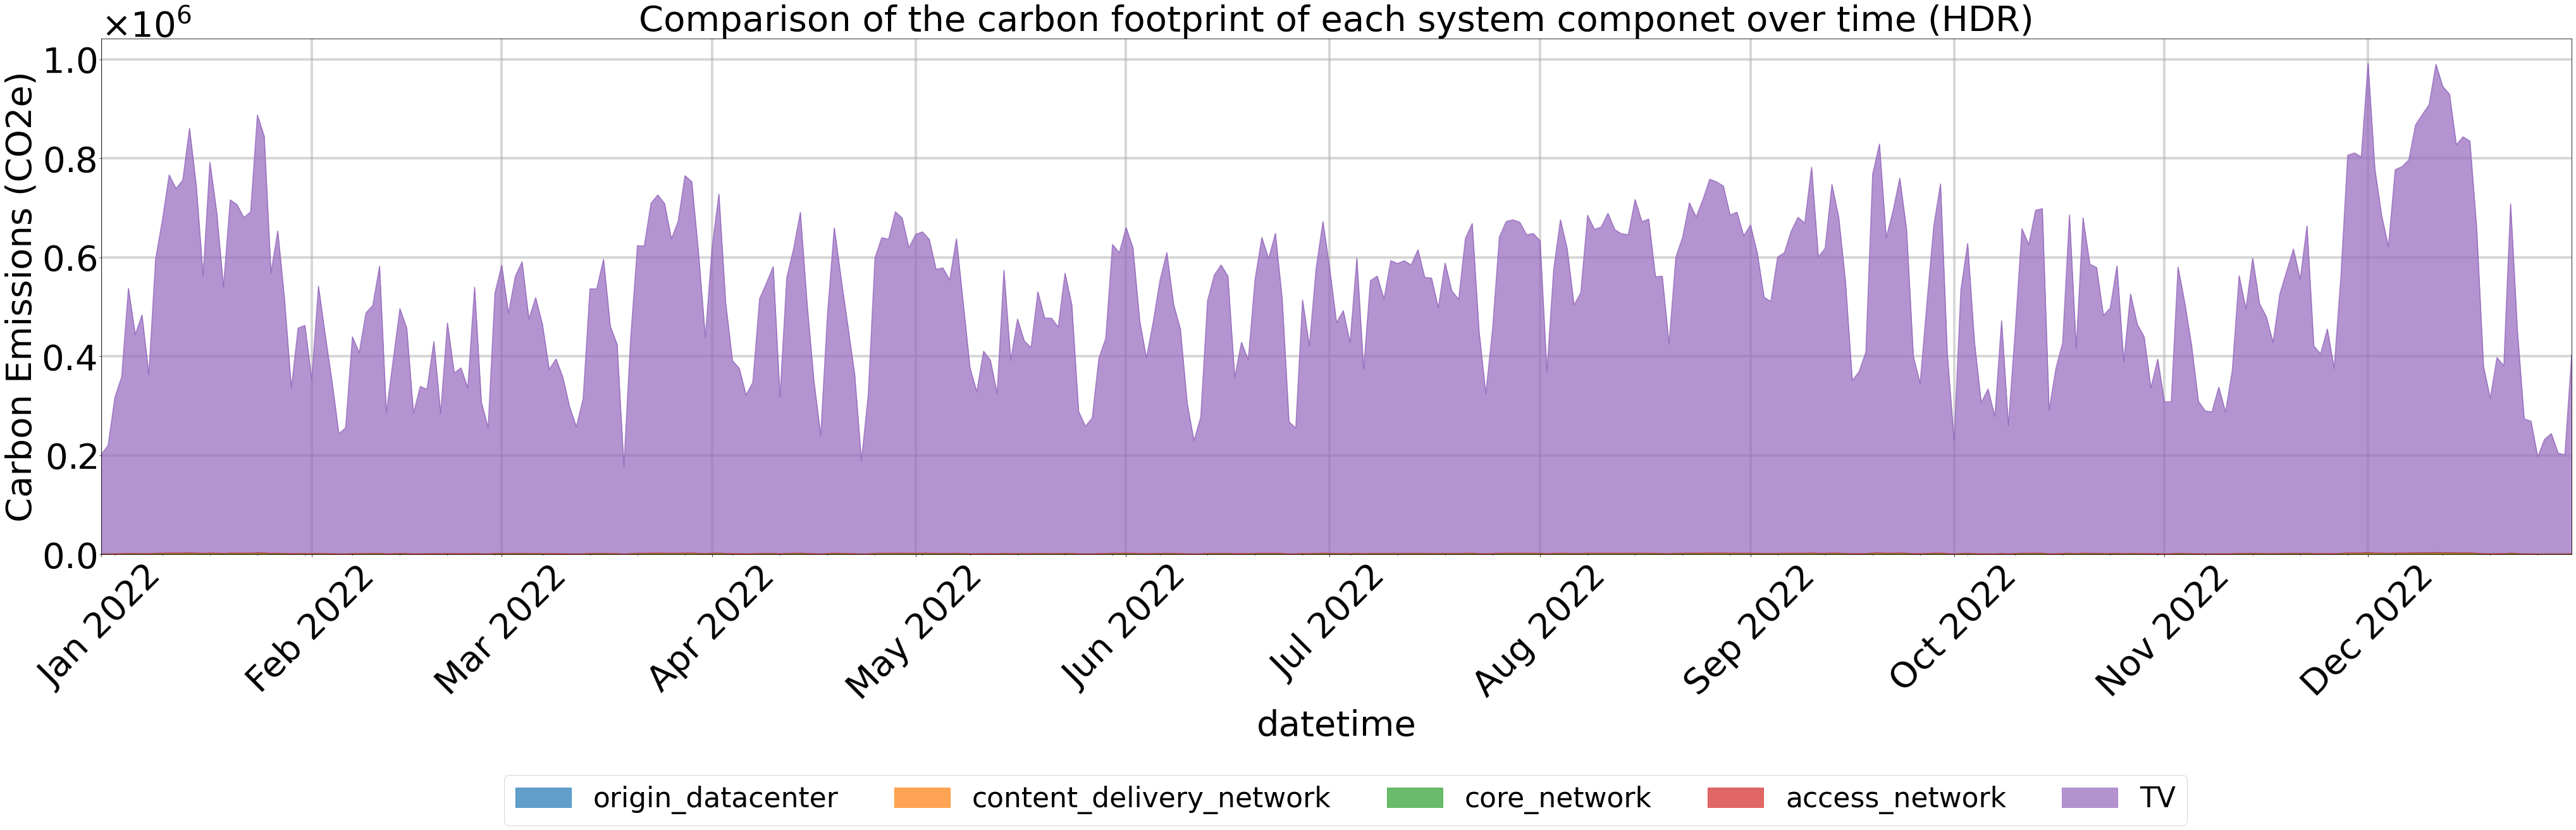

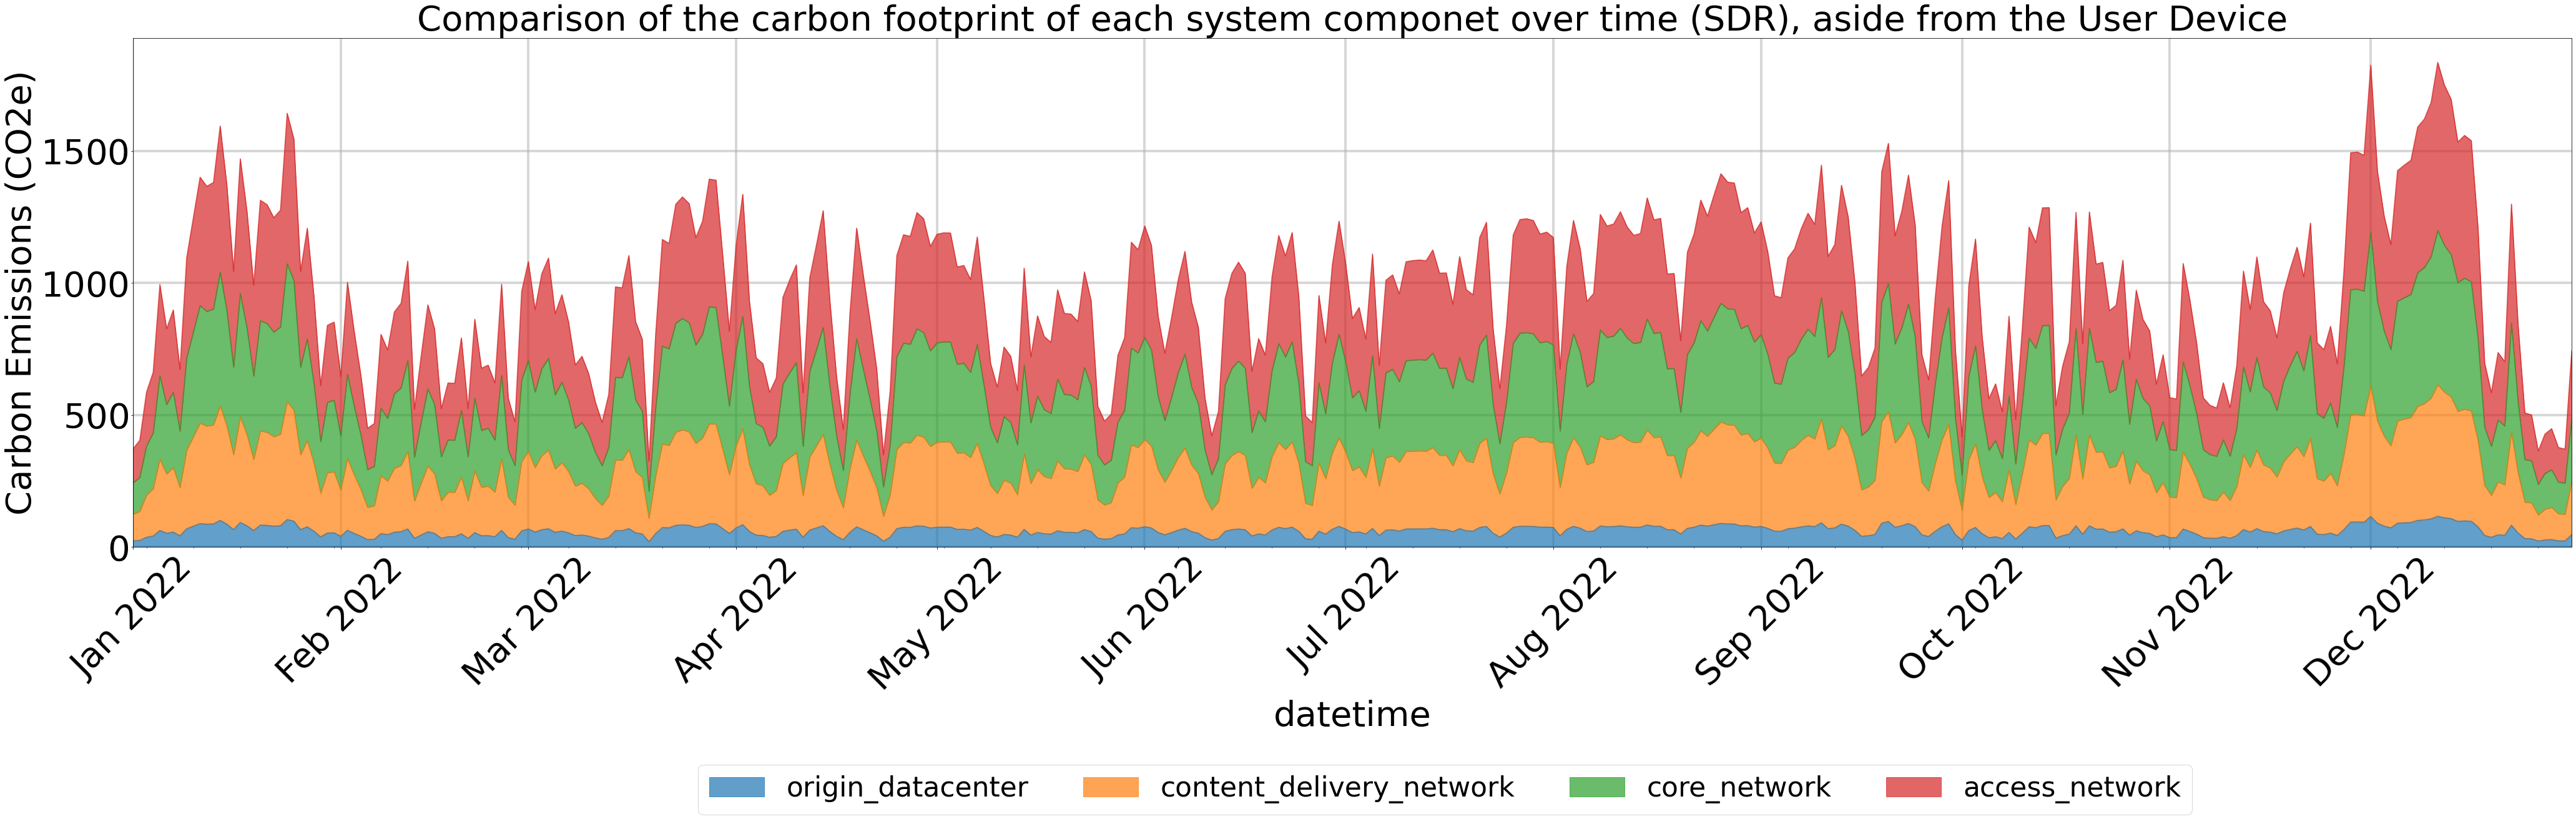

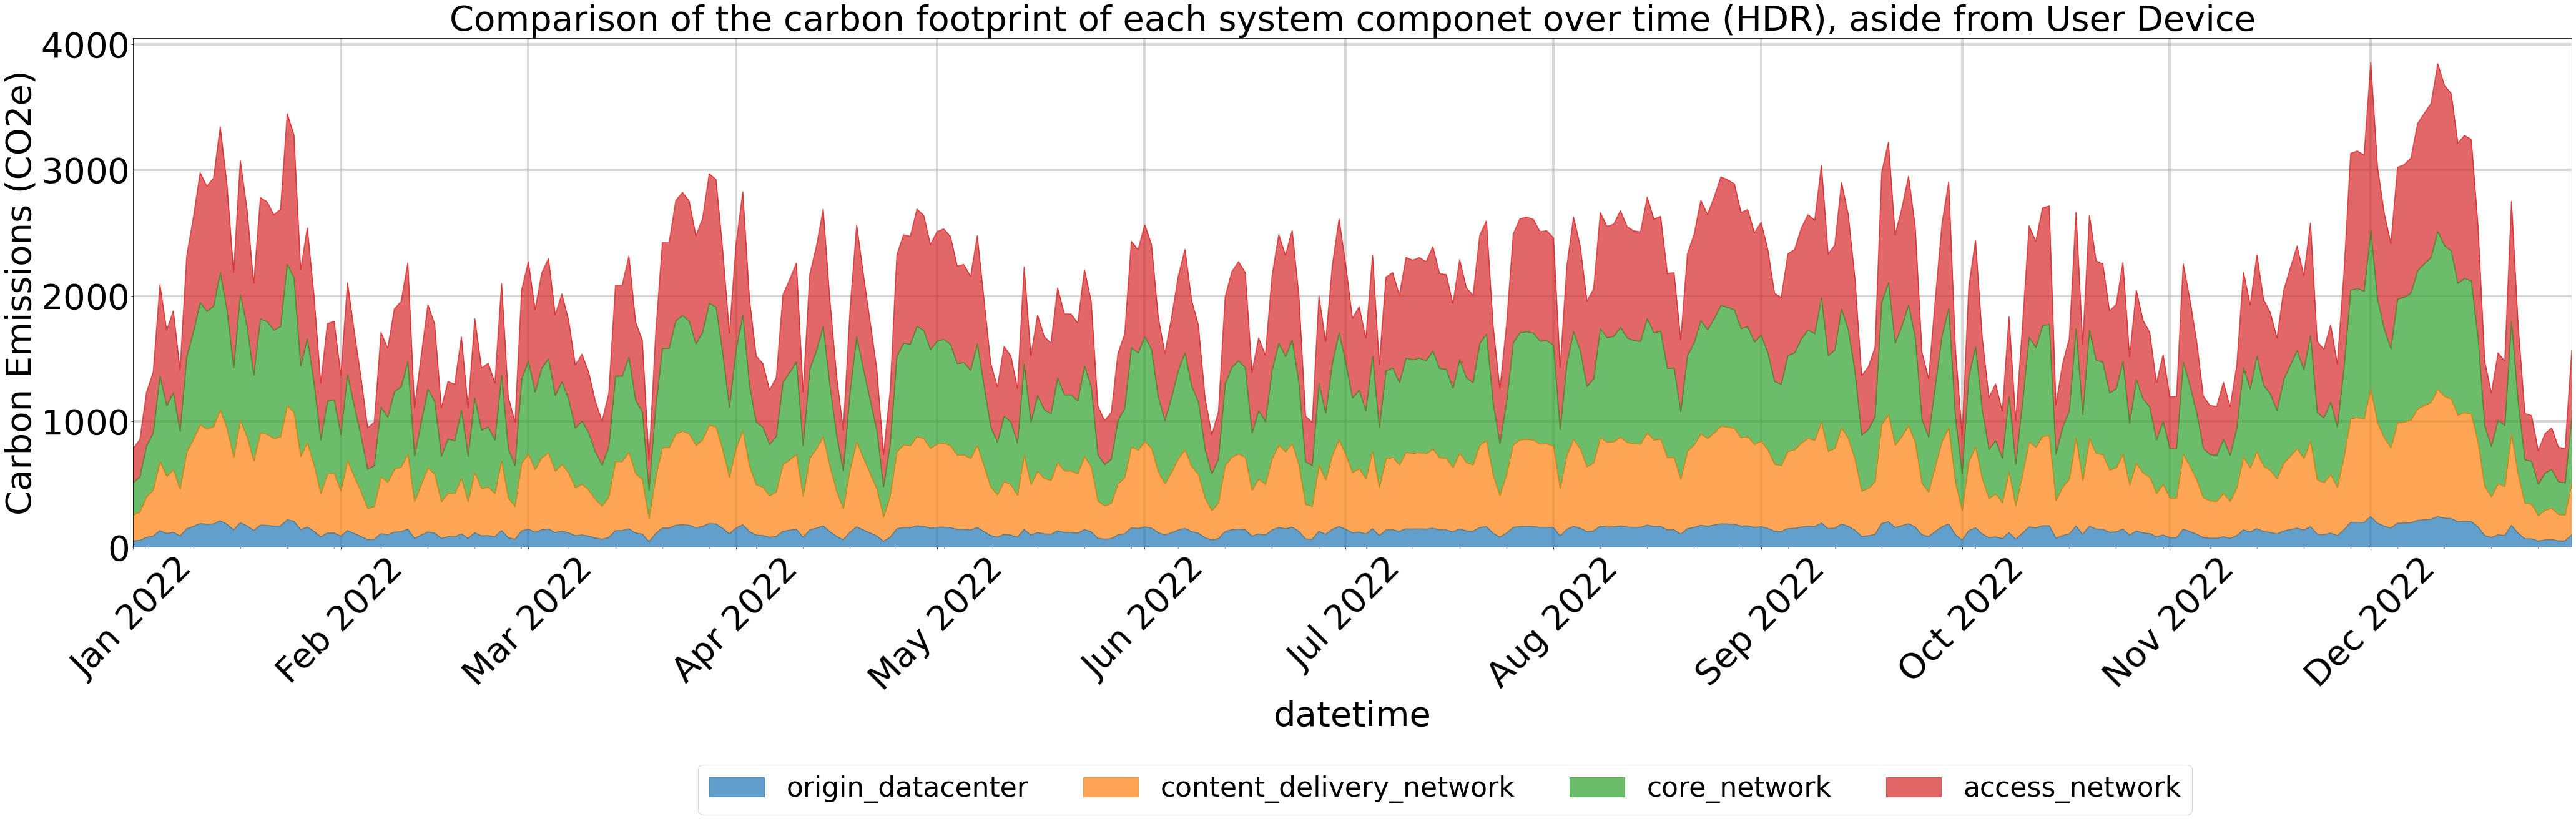

In [23]:
plot_system_components(BASE_sdr_daily,True, "Comparison of the carbon footprint of each system componet over time (SDR)", "datetime", "Carbon Emissions (CO2e)",fontsize,legend_fontsize,grid_width,None)


plot_system_components(BASE_hdr_daily,True, "Comparison of the carbon footprint of each system componet over time (HDR)", "datetime", "Carbon Emissions (CO2e)",fontsize,legend_fontsize,grid_width,"system_com_comparison")
#Save ^ this 
plot_system_components(BASE_sdr_daily,False, "Comparison of the carbon footprint of each system componet over time (SDR), aside from the User Device", "datetime", "Carbon Emissions (CO2e)",fontsize,legend_fontsize,grid_width,None)

plot_system_components(BASE_hdr_daily,False, "Comparison of the carbon footprint of each system componet over time (HDR), aside from User Device", "datetime", "Carbon Emissions (CO2e)",fontsize,legend_fontsize,grid_width,"system_com_comparison_ex_TV")
#Save ^ this 

# Comparison of audience growth rates with HDR image

- BASE is a 8% increase over the year
- AUD2 is a 10% increase over the year
- AUD3 is a 12% increase over the yeat

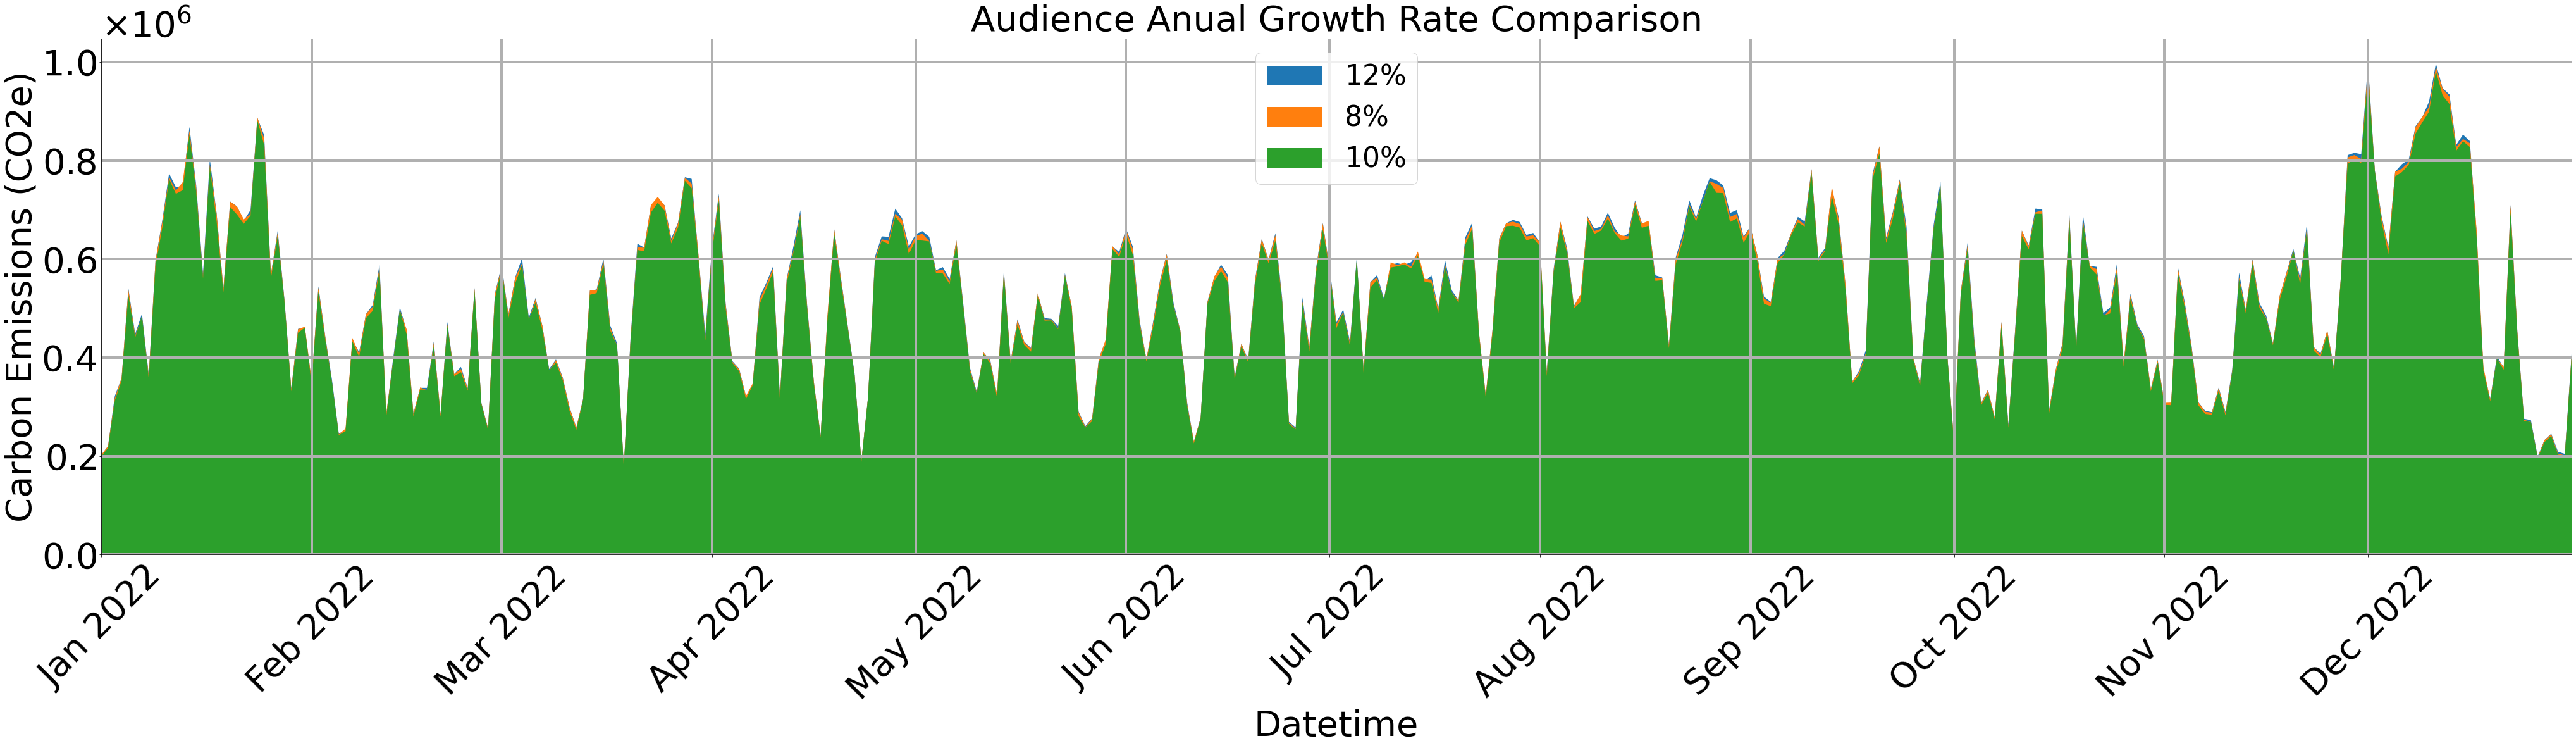

In [25]:
AUD2_hdr_daily = resample_daily(AUD2_hdr)

AUD3_hdr_daily = resample_daily(AUD3_hdr)

plot_year(BASE_hdr_daily.index,[AUD3_hdr_daily["total"],BASE_hdr_daily["total"],AUD2_hdr_daily["total"]], "Datetime", "Carbon Emissions (CO2e)","Audience Anual Growth Rate Comparison",["12%","8%","10%"],fontsize,legend_fontsize,grid_width,None)

In [27]:
AUD2_difference = AUD2_hdr_summary["total"] - BASE_hdr_summary["total"]
print("10% difference in carbon fooprint compared to 8% = " +str(AUD2_difference))

AUD3_difference = AUD3_hdr_summary["total"] - BASE_hdr_summary["total"]
print("12% difference in carbon fooprint compared to 8% = " +str(AUD3_difference))
#table

10% difference in carbon fooprint compared to 8% = -2198898.2577087283
12% difference in carbon fooprint compared to 8% = 979912.913138777


# Comparison of Storage Type

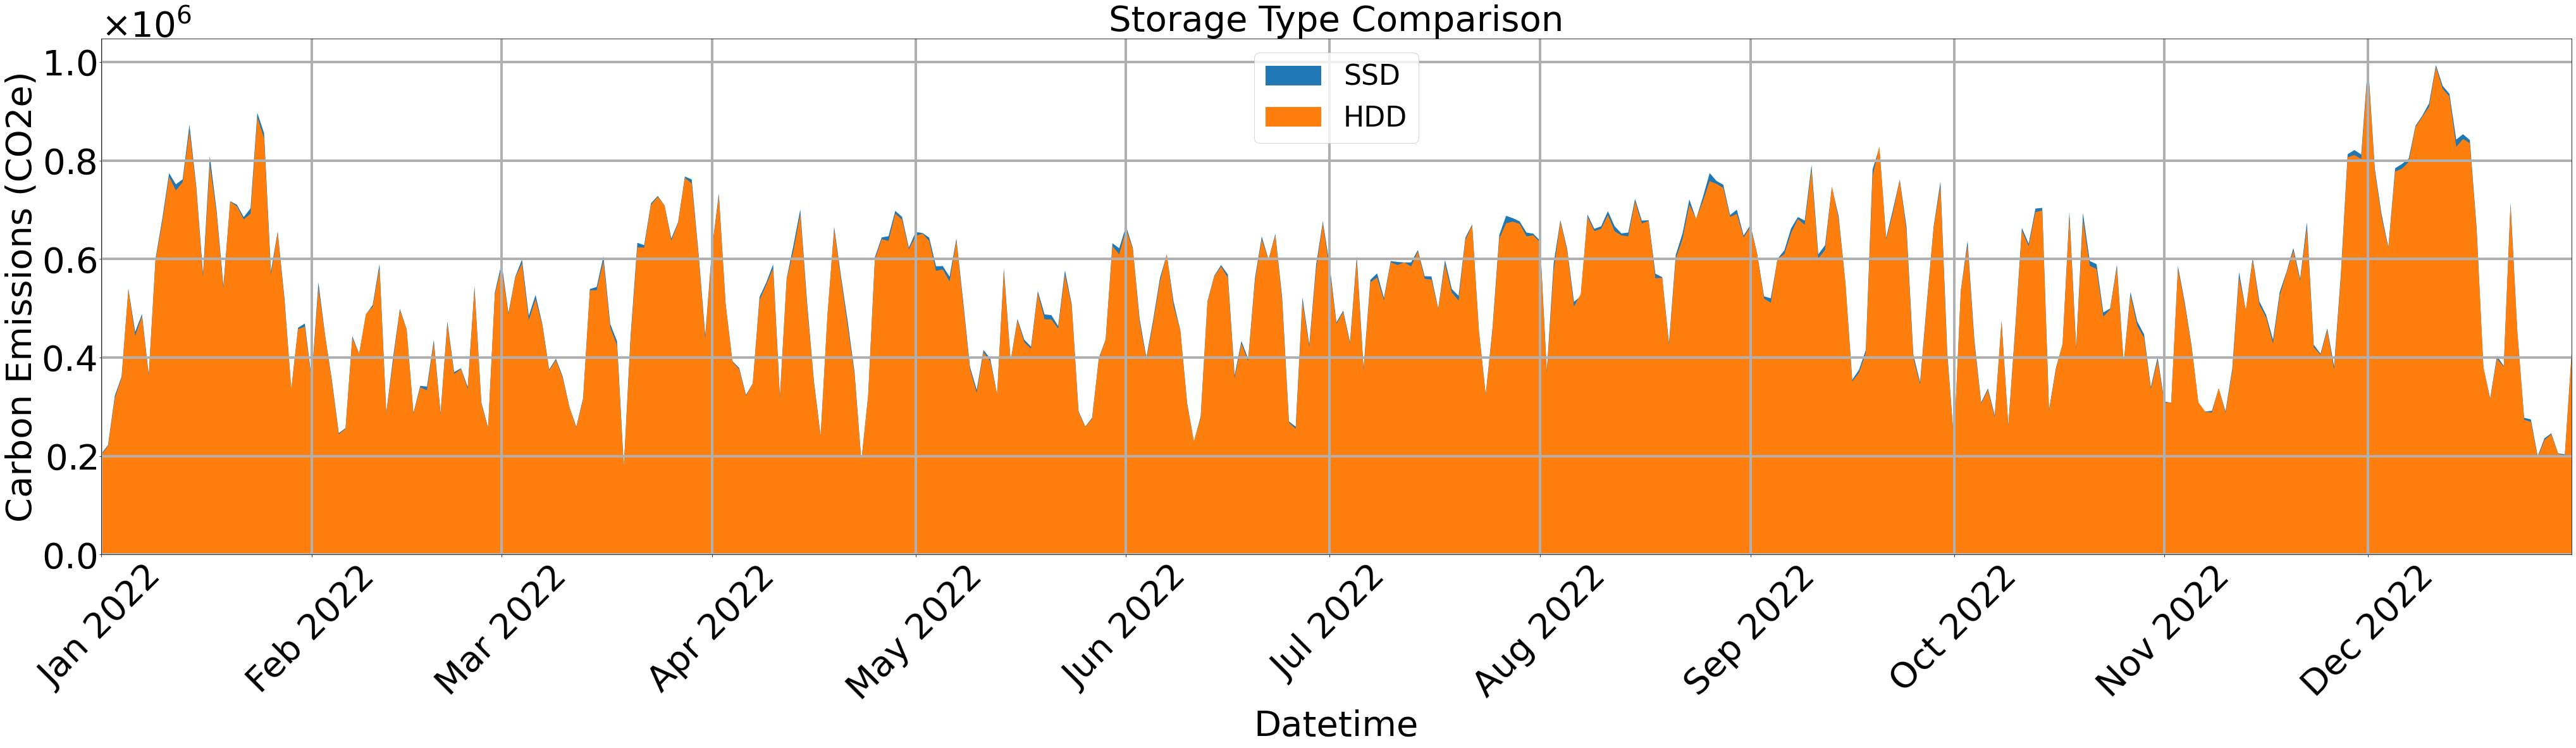

In [28]:
STR2_hdr_daily = resample_daily(STR2_hdr)

plot_year(BASE_hdr_daily.index,[STR2_hdr_daily["total"],BASE_hdr_daily["total"]], "Datetime", "Carbon Emissions (CO2e)","Storage Type Comparison",["SSD","HDD"],fontsize,legend_fontsize,grid_width,None)

In [29]:
#Stat difference
STR_difference = STR2_hdr_summary["total"] - BASE_hdr_summary["total"]
print("SDD differnce in total carbon emissons = " +str(STR_difference))

STR_cdn_differnce = STR2_hdr_summary["origin_datacenter"] - BASE_hdr_summary["origin_datacenter"]
print("SDD differnce in origin datacenter carbon emissons = " +str(STR_cdn_differnce))

STR_cdn_differnce = STR2_hdr_summary["content_delivery_network"] - BASE_hdr_summary["content_delivery_network"]
print("SDD differnce in CDN carbon emissons = " +str(STR_cdn_differnce))
#Table 

SDD differnce in total carbon emissons = 1815718.0924839973
SDD differnce in origin datacenter carbon emissons = 254.33371969285508
SDD differnce in CDN carbon emissons = 4774.795124108467


# Comparison of Energy consuption vs Carbon Footprint

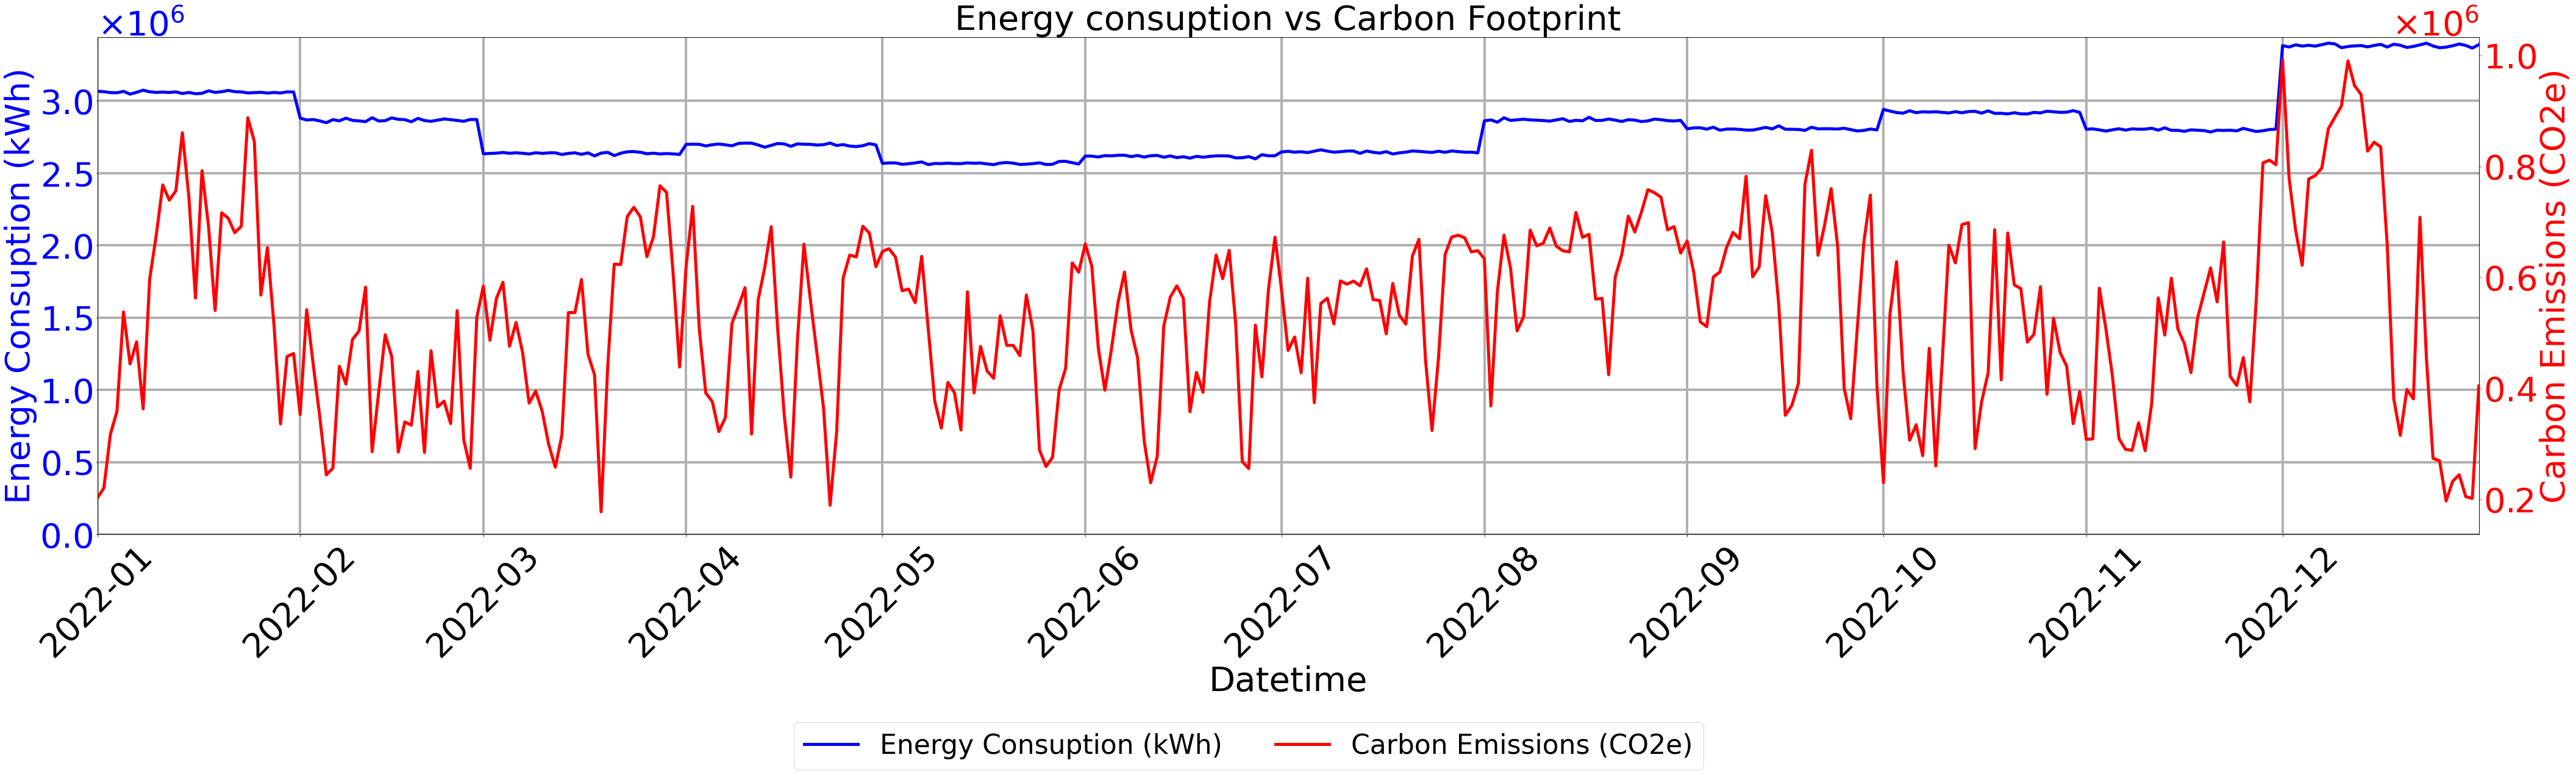

In [30]:
BASE_energy_hdr_daily = resample_daily(BASE_energy_hdr)

plot_year_twin(BASE_hdr_daily.index, BASE_energy_hdr_daily["total"], BASE_hdr_daily["total"], "Datetime", "Energy Consuption (kWh)", "Carbon Emissions (CO2e)", "Energy consuption vs Carbon Footprint", fontsize, legend_fontsize, grid_width,line_width,"energy_carbon")
#Save ^ this 